In [14]:
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr
import random 
import os 
import pandas as pd 

from global_land_mask import globe

from work import handler
from work import casestudy
from work import storm_tracker
from work.ml_tools.standard_scaler_from_ds import scale_profiles
from work.plots.hist import simple_hist

settings_path = 'settings/sam3d.yaml'

hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 1.33 seconds


In [15]:
duration_min = 6  # or 10
surfmaxkm2_min = 10000  # or other value
region_latmin, region_latmax, region_lonmin, region_lonmax = -15, 30, -180, 180
filename_save = f"wind_init_profile_dataset_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, filename_save)
ds = xr.open_dataset(storms_path)

filename_save = f"rcond_sigma_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, filename_save)
storms = xr.open_dataset(storms_path)
storms_aligned = storms.reindex(DCS_number=ds['DCS_number'], method=None)  # No interpolation

all_storms = xr.open_dataset(st.file_storms)
all_storms_aligned = all_storms.reindex(DCS_number=ds['DCS_number'], method=None)  # No interpolation
ds = xr.merge([ds, storms_aligned, all_storms_aligned])

def is_ocean(lat1, lon1):
    return not globe.is_land(lat1, lon1)

mask = xr.apply_ufunc(is_ocean,ds["lat_init"],ds["lon_init"], vectorize=True)
ds = ds.where(mask, drop=True)
# ds = ds.drop_isel(DCS_number = [250, 266, 267, 284, 285, 286, 307]) # see data_miniz_viz.ipynb, auto_encoder_v3
ds = ds.sel(z=ds.z<=8000)

ds

<xarray.Dataset>
Dimensions:              (DCS_number: 3951, z: 38, time: 911)
Coordinates:
  * DCS_number           (DCS_number) int64 153383 153384 ... 299288 299316
  * z                    (z) float32 20.0 61.2 104.9 ... 7.466e+03 7.966e+03
  * time                 (time) int64 817681 817682 817683 ... 818590 818591
Data variables: (12/70)
    U_init_profile       (DCS_number, z) float64 11.01 13.93 ... 25.36 28.44
    V_init_profile       (DCS_number, z) float64 9.497 11.38 ... -0.7721 0.07896
    lon_init             (DCS_number) float64 144.3 148.9 ... -161.4 -108.5
    lat_init             (DCS_number) float64 11.87 11.06 12.61 ... 24.29 -30.93
    time_init            (DCS_number) float64 1.008e+03 1.008e+03 ... 1.884e+03
    INT_UTC_timeInit     (DCS_number) float64 1.472e+09 1.472e+09 ... 1.473e+09
    ...                   ...
    LC_tbavg_208K        (DCS_number, time) float64 198.0 199.3 ... nan nan
    LC_tbavg_241K        (DCS_number, time) float64 204.9 205.8 ... nan nan
    LC_tbmin             (DCS_number, time) float64 188.0 189.0 ... nan nan
    LC_x                 (DCS_number, time) float64 3.693e+03 3.693e+03 ... nan
    LC_y                 (DCS_number, time) float64 1.342e+03 1.344e+03 ... nan
    QCgeo_IRimage        (DCS_number, time) float64 1.0 1.0 1.0 ... nan nan nan

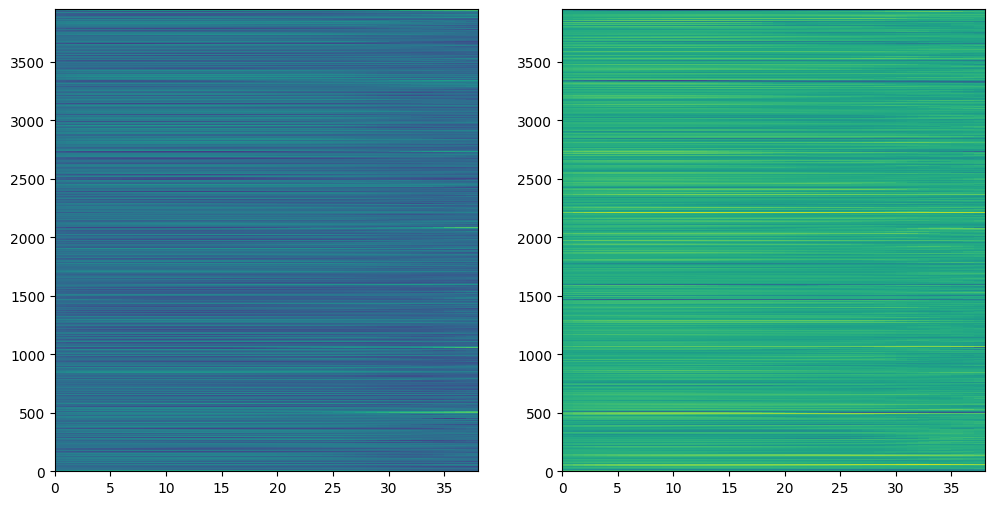

In [16]:
u_init = ds["U_init_profile"]
v_init = ds["V_init_profile"]

fig, axs = plt.subplots(1,2, figsize = (12,6))
axs[0].pcolormesh(u_init)
# print(u_init.shape[0], "DCS before TABS bug")
# print(np.unique(np.where(u_init.values==0)[0]), "fucked TABS init bug")
axs[1].pcolormesh(v_init)
# print(np.unique(np.where(v_init==0)[0]), "fucked TABS max bug")

fucked_DCS = ds.DCS_number.values[np.any(np.isnan(u_init.values), axis = 1)]
ds = ds.drop_sel(DCS_number = fucked_DCS)

In [17]:
filename_save = f"rcond_sigma_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, filename_save)
ds_rcond = xr.open_dataset(storms_path)
ds_rcond = ds_rcond.reindex(DCS_number=ds['DCS_number'], method=None) ## this is actually filtering

weaks_iDCS = ds_rcond.DCS_number[np.isnan(ds_rcond["INT_rcond_30mmh"].values)]
ds = ds.drop_sel(DCS_number = weaks_iDCS)

In [18]:
DCS_numbers = ds.DCS_number.values
lon_max_list = []
lat_max_list = []
time_max_list = []
for iDCS, DCS_number in enumerate(DCS_numbers):
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(ds, DCS_number)
    lon_max_list.append(lons[i_smax+1])
    lat_max_list.append(lats[i_smax+1])
    time_max_list.append(time_smax)
    
ds["lon_max_instant"] = xr.DataArray(np.array(lon_max_list), dims = ["DCS_number"], coords = {"DCS_number" : ds.DCS_number})
ds["lat_max_instant"] = xr.DataArray(np.array(lat_max_list), dims = ["DCS_number"], coords = {"DCS_number" : ds.DCS_number})
ds["time_max_instant"] = xr.DataArray(np.array(lat_max_list), dims = ["DCS_number"], coords = {"DCS_number" : ds.DCS_number})

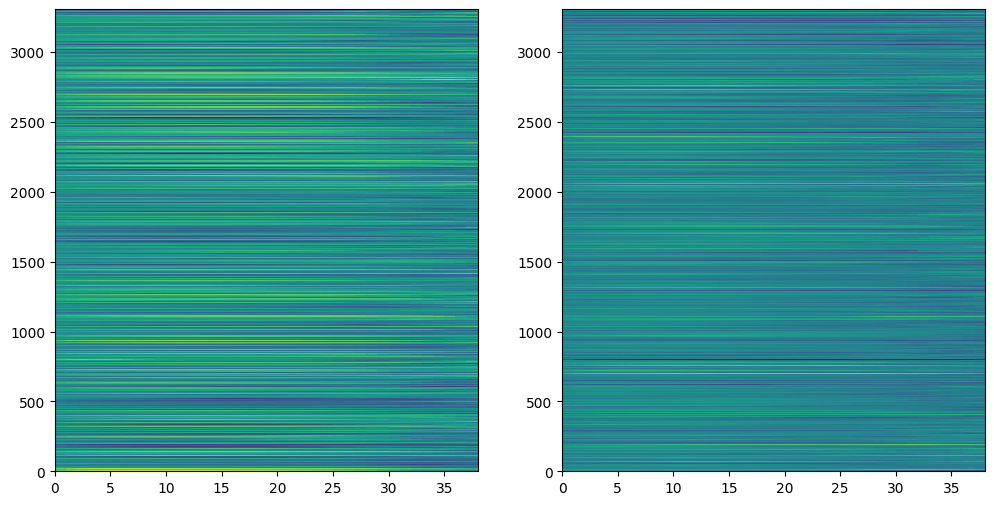

In [19]:
u_init = ds["U_init_profile"]
v_init = ds["V_init_profile"]

fig, axs = plt.subplots(1,2, figsize = (12,6))
axs[0].pcolormesh(u_init)
# print(u_init.shape[0], "DCS before TABS bug")
# print(np.unique(np.where(u_init.values==0)[0]), "fucked TABS init bug")
axs[1].pcolormesh(v_init)
# print(np.unique(np.where(v_init==0)[0]), "fucked TABS max bug")

fucked_DCS = ds.DCS_number.values[np.any(np.isnan(u_init.values), axis = 1)]
ds = ds.drop_sel(DCS_number = fucked_DCS)

In [23]:
X_prec = np.stack([
    ds["INT_rcond_1mmh"].values,
    ds["INT_rcond_10mmh"].values,
    ds["INT_rcond_30mmh"].values,
    ds["INT_sigma_1mmh"].values,
    ds["INT_sigma_10mmh"].values,
    ds["INT_sigma_30mmh"].values
    ], axis=1)

X_morpho = np.stack([
    ds["INT_TbMin"], 
    ds["INT_surfmaxkm2_241K"], 
    ds["INT_velocityAvg"],
    ds["INT_duration"],
    # ds["INT_"]
], axis=1)

In [21]:
# from work.ml_tools.standard_scaler_from_ds import scale_profiles
from work.ml_tools.standard_scaler_from_ds import scale_profiles_v4

X, X_scaled, scaler_profiles = scale_profiles_v4(ds)

In [22]:
from tensorflow import keras
latent_space_size = 6
model_name = 'ae_fully_connected_v4'+f"_latent_{latent_space_size}"
ae_name = f'{model_name}_v0.keras'

save_path_ae = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, ae_name)

# Load the autoencoder
autoencoder = keras.models.load_model(save_path_ae)
# Print the model summary to identify layers
autoencoder.summary()

Model: "ae_fully_connected_v4_latent_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 34, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 68)             │        17,476 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 34, 2)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,192 (1.18 MB)

 Trainable params: 102,730 (401.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 205,462 (802.59 KB)

In [24]:
# Using the name of the bottleneck layer
encoder_output = autoencoder.get_layer('dense_2').output  # Replace 'bottleneck' with actual name

# Or, if you know the index of the bottleneck layer
# encoder_output = autoencoder.layers[n].output  # Replace n with the actual index

# Reconstruct the encoder model
encoder = keras.Model(inputs=autoencoder.input, outputs=encoder_output)
print("Autoencoder input shape:", autoencoder.input_shape)
print("X_scaled shape:", X_scaled.shape)

# Encode the data
X_latent = encoder.predict(X_scaled)
print(np.where((np.sum(X_latent, axis=0)==0)))
X_latent = X_latent[:, ~(np.sum(X_latent, axis=0)==0)]
print("Latent representation shape:", X_latent.shape)

Autoencoder input shape: (None, 34, 2)
X_scaled shape: (3306, 34, 2)
  1/104 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(array([], dtype=int64),)
Latent representation shape: (3306, 6)


In [25]:
X_clustering = np.hstack([X_latent, X_prec, X_morpho]) 
##########################
### -- Some Rcond are nans, very weak MCS ###
X_clustering = X_clustering[~np.isnan(X_clustering).any(axis=1)] 
# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

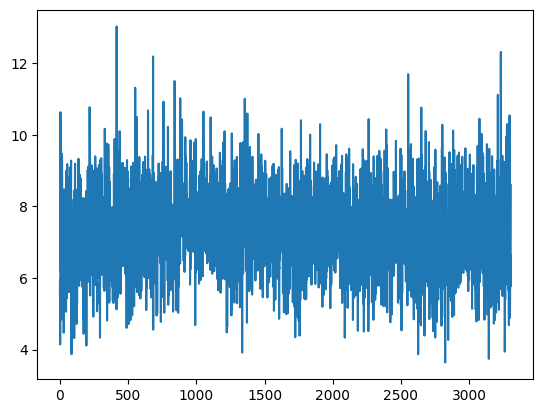

In [26]:
plt.plot(X_prec[:,0])

## PCA + K-MEANS

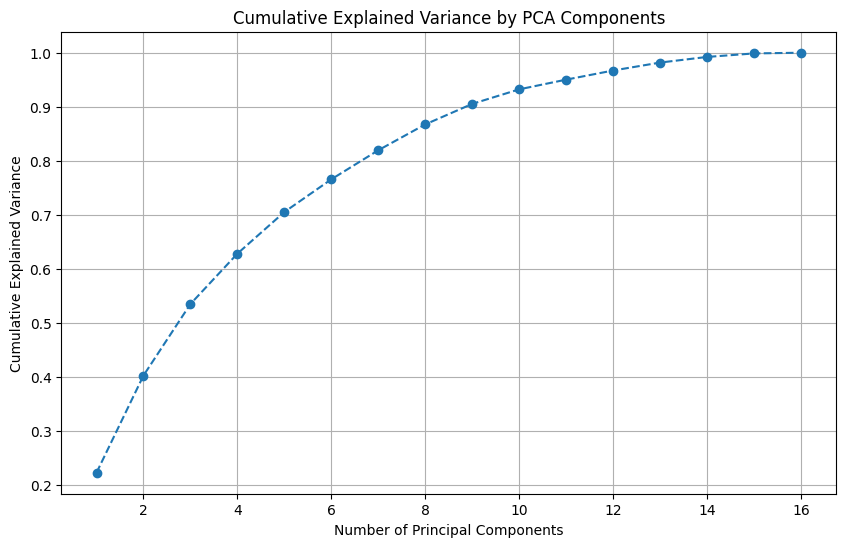

In [27]:
# Step 1: Standardize and Apply PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Apply PCA to get all components
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)
explained_variance_ratio = pca_full.explained_variance_ratio_

# Step 2: Plot the Explained Variance Ratio
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Step 3: Decide on Number of Principal Components
n_components = 12  # Adjust based on the plot
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python

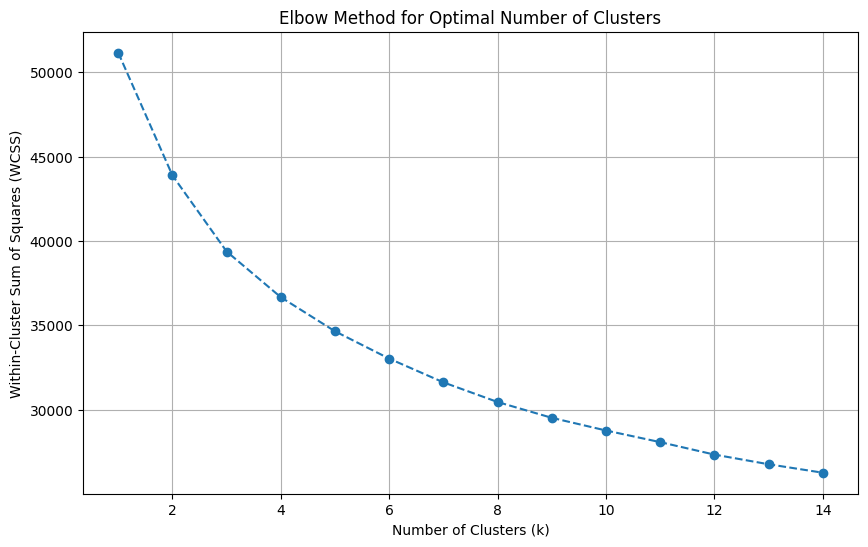

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


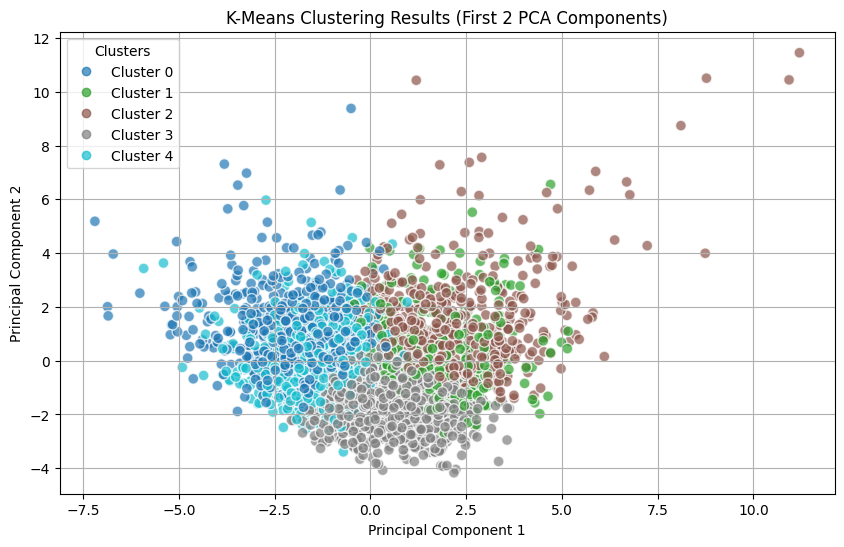

In [29]:
# Step 4: Perform K-Means Clustering and Create Elbow Plot
from sklearn.cluster import KMeans

cluster_range = range(1, 15)
wcss = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

# Step 5: Decide on Number of Clusters
optimal_k = 5  # Adjust based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Step 6: Visualize the Clusters
# Option A: 2D Visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=cluster_labels,
    cmap='tab10',
    s=60,
    alpha=0.7,
    edgecolors='w'
)
handles, _ = scatter.legend_elements()
legend_labels = [f"Cluster {i}" for i in range(optimal_k)]
plt.legend(handles, legend_labels, title="Clusters", loc='best')
plt.title('K-Means Clustering Results (First 2 PCA Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


## UMAP + HDBSCAN

/home/mcarenso/virtual_envs/PyHD/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape of X_umap: (3306, 2)


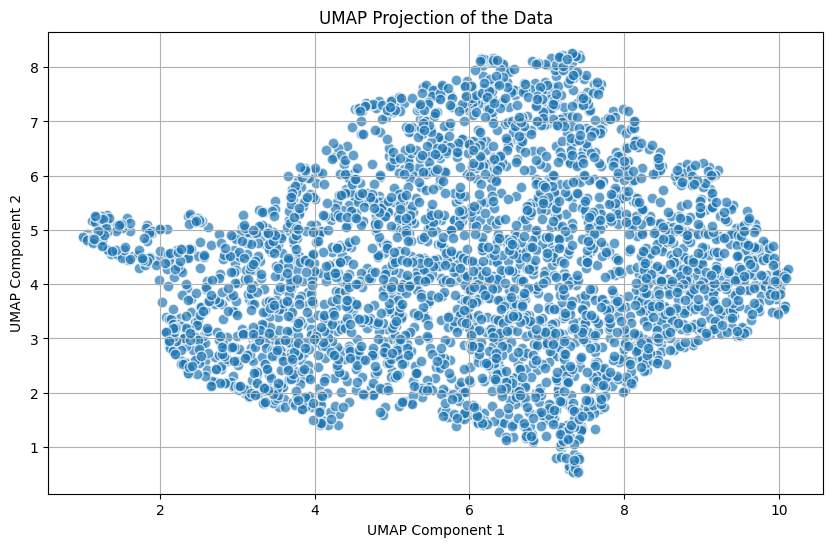

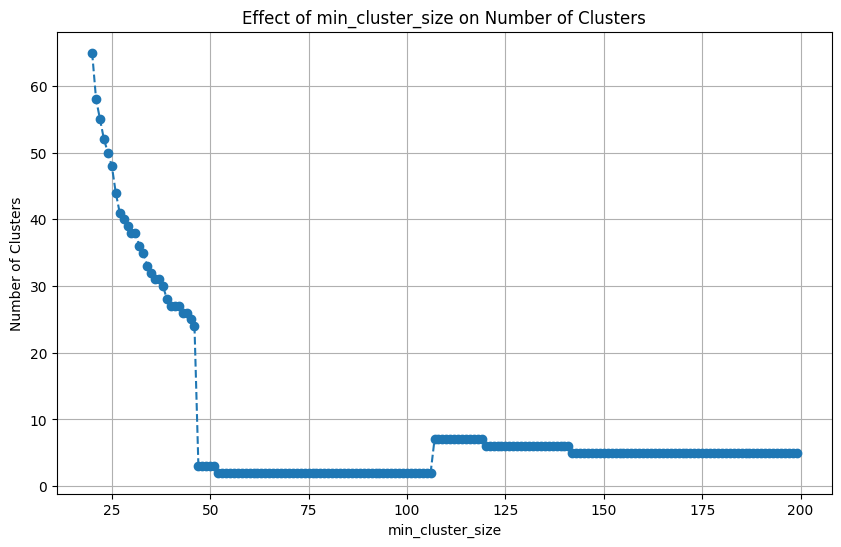

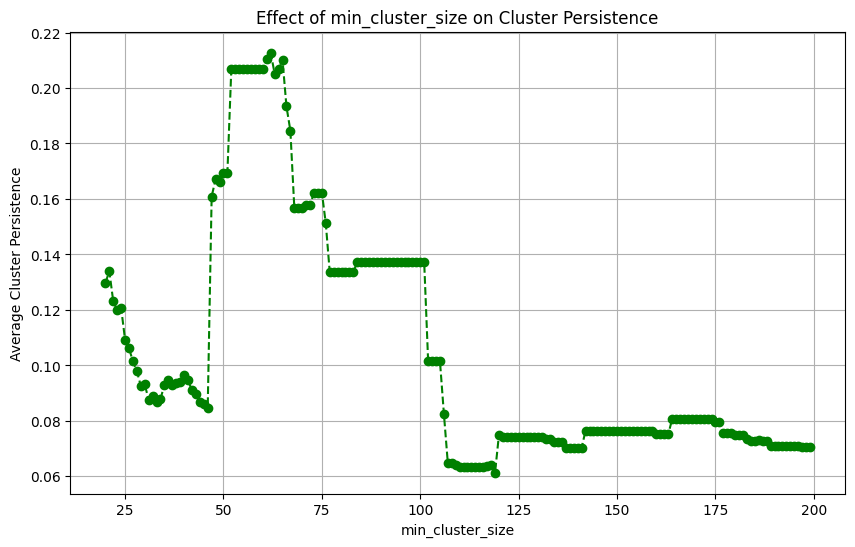

Number of clusters found: 3


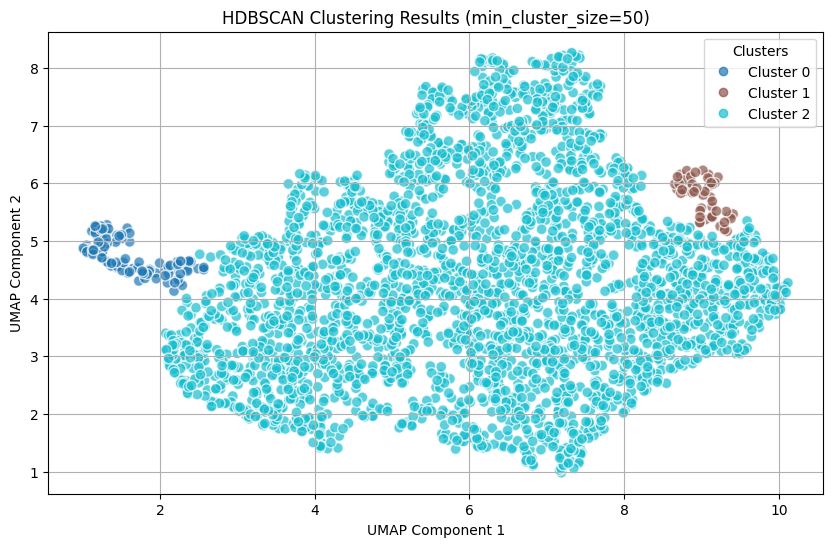

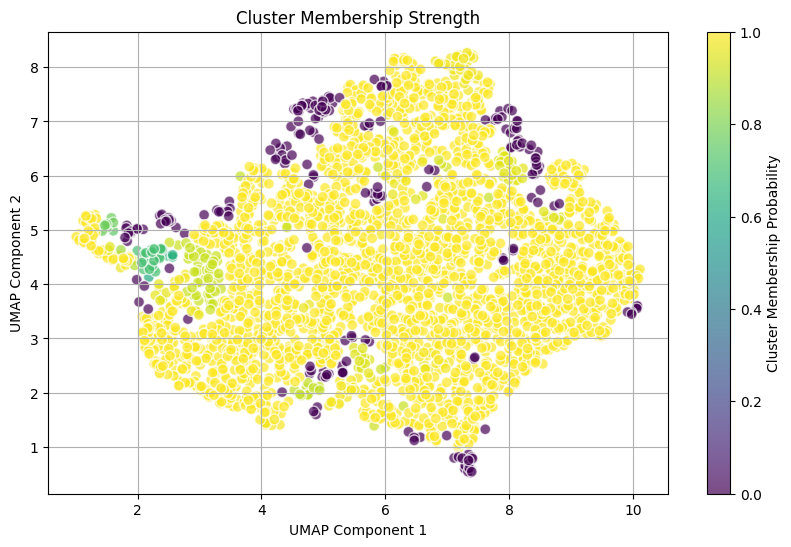

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import umap
import hdbscan

# Step 2: Apply UMAP for Dimensionality Reduction
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
print("Shape of X_umap:", X_umap.shape)

# Plot UMAP Embeddings
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=60, alpha=0.7, edgecolors='w')
plt.title('UMAP Projection of the Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

# Step 3: Explore HDBSCAN Parameters
min_cluster_sizes = range(20, 200)  # Adjust the range as needed
num_clusters = []
cluster_persistences = []

for min_cluster_size in min_cluster_sizes:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=1,
        metric='euclidean',
        cluster_selection_method='eom'
    )
    cluster_labels = clusterer.fit_predict(X_umap)
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    num_clusters.append(n_clusters)
    # Average cluster persistence (measure of cluster stability)
    cluster_persistence = np.mean(clusterer.cluster_persistence_)
    cluster_persistences.append(cluster_persistence)

# Plot Number of Clusters vs. min_cluster_size
plt.figure(figsize=(10, 6))
plt.plot(min_cluster_sizes, num_clusters, marker='o', linestyle='--')
plt.title('Effect of min_cluster_size on Number of Clusters')
plt.xlabel('min_cluster_size')
plt.ylabel('Number of Clusters')
plt.grid(True)
plt.show()

# Plot Average Cluster Persistence vs. min_cluster_size
plt.figure(figsize=(10, 6))
plt.plot(min_cluster_sizes, cluster_persistences, marker='o', linestyle='--', color='green')
plt.title('Effect of min_cluster_size on Cluster Persistence')
plt.xlabel('min_cluster_size')
plt.ylabel('Average Cluster Persistence')
plt.grid(True)
plt.show()

# Step 4: Perform HDBSCAN Clustering with Optimal min_cluster_size
########!!!!!!!!!!!!!!!!!!!!!!!################
optimal_min_cluster_size = 50  # Adjust based on your analysis
########!!!!!!!!!!!!!!!!!!!!!!!################

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=optimal_min_cluster_size,
    min_samples=1,
    metric='euclidean',
    cluster_selection_method='eom'
)
cluster_labels = clusterer.fit_predict(X_umap)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Number of clusters found: {n_clusters}")

# Step 5: Visualize Clustering Results
plt.figure(figsize=(10, 6))

# Exclude noise points (optional)
mask = cluster_labels != -1
X_plot = X_umap[mask]
labels_plot = cluster_labels[mask]

scatter = plt.scatter(
    X_plot[:, 0], X_plot[:, 1],
    c=labels_plot,
    cmap='tab10',
    s=60,
    alpha=0.7,
    edgecolors='w'
)

# Add Legend
handles, _ = scatter.legend_elements()
legend_labels = [f"Cluster {i}" for i in set(labels_plot)]
plt.legend(handles, legend_labels, title="Clusters", loc='best')

plt.title(f'HDBSCAN Clustering Results (min_cluster_size={optimal_min_cluster_size})')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

# Step 6: Optional - Visualize Cluster Probabilities
plt.figure(figsize=(10, 6))
plt.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=clusterer.probabilities_,
    cmap='viridis',
    s=60,
    alpha=0.7,
    edgecolors='w'
)
plt.colorbar(label='Cluster Membership Probability')
plt.title('Cluster Membership Strength')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

In [16]:
# Save UMAP embeddings and cluster labels as numpy arrays
X_umap_name = "X_umap_v1.npy"
X_umap_savepath = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, X_umap_name) 
np.save(X_umap_savepath, X_umap)

clusters_name = "hdbscan_labels_v0_of_X_umap_v1.npy"
clusters_savepath = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, clusters_name)
np.save(clusters_savepath, cluster_labels)

In [17]:
cluster_labels.shape

(317,)

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python

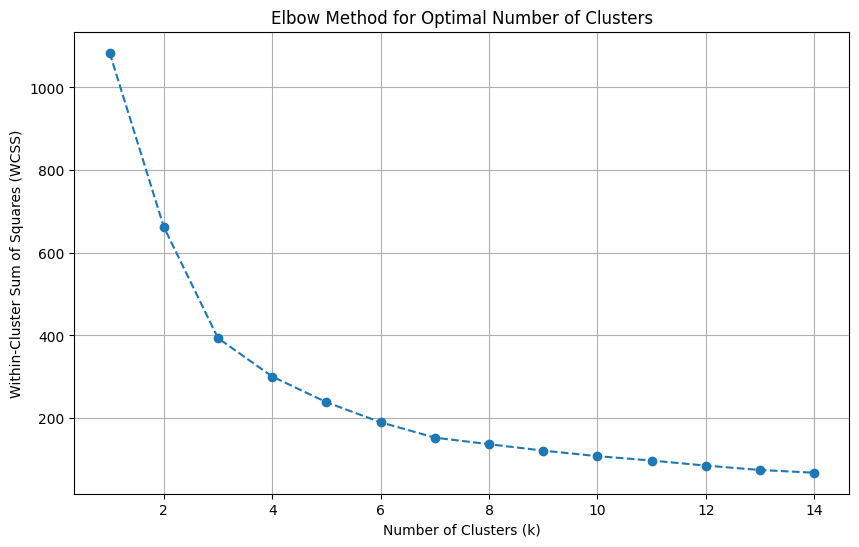

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


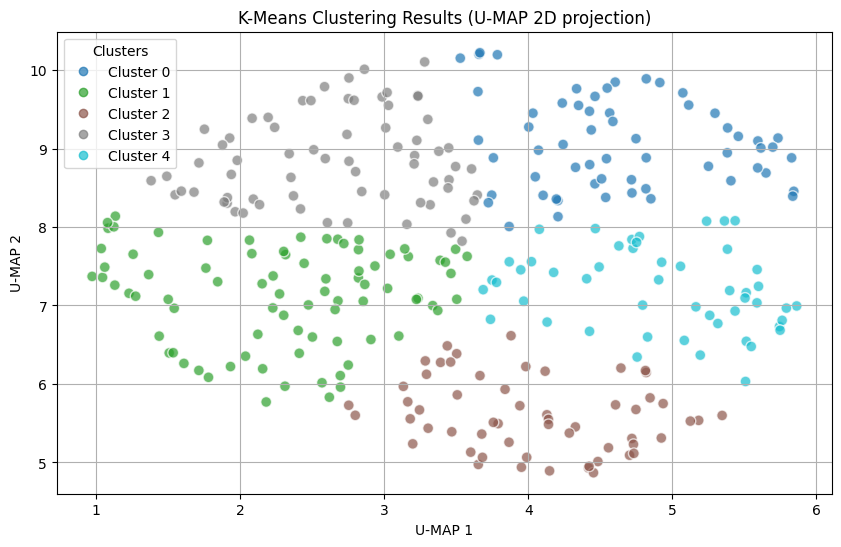

In [12]:
# Step 4: Perform K-Means Clustering and Create Elbow Plot
from sklearn.cluster import KMeans

cluster_range = range(1, 15)
wcss = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_umap)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

# Step 5: Decide on Number of Clusters
optimal_k = 5  # Adjust based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(X_umap)

# Step 6: Visualize the Clusters
# Option A: 2D Visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=cluster_labels,
    cmap='tab10',
    s=60,
    alpha=0.7,
    edgecolors='w'
)
handles, _ = scatter.legend_elements()
legend_labels = [f"Cluster {i}" for i in range(optimal_k)]
plt.legend(handles, legend_labels, title="Clusters", loc='best')
plt.title('K-Means Clustering Results (U-MAP 2D projection)')
plt.xlabel('U-MAP 1')
plt.ylabel('U-MAP 2')
plt.grid(True)
plt.show()

In [43]:
import pickle
import joblib
##########################
#### -- save stuff -- ####
##########################

# Save UMAP reducer
umap_name = "umap_reducer_v0.pkl"

umap_save_path = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, umap_name)
with open('umap_reducer.pkl', 'wb') as f:
    pickle.dump(reducer, f)

# Save HDBSCAN clusterer
clusterer_name = "hdbscan_v0.joblib"
clusterer_savepath = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, clusterer_name)
joblib.dump(clusterer, clusterer_savepath)

# Save UMAP embeddings and cluster labels as numpy arrays
X_umap_name = "X_umap_v0.npy"
X_umap_savepath = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, X_umap_name) 
np.save(X_umap_savepath, X_umap)

clusters_name = "hdbscan_labels_v0_of_X_umap_v0.npy"
clusters_savepath = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, clusters_name)
np.save(clusters_savepath, cluster_labels)

In [46]:
cluster_labels.shape

(317,)

## Old

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-

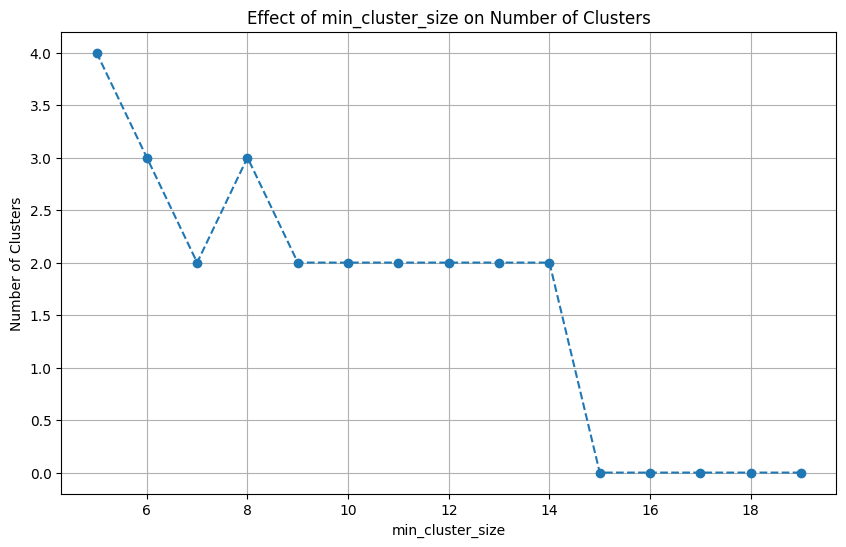

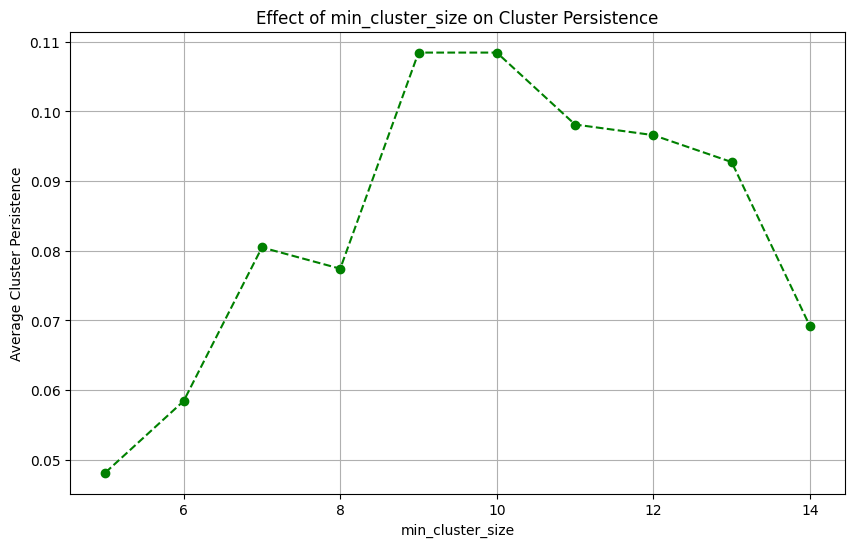

In [12]:
import hdbscan

# Initialize lists to store clustering results
min_cluster_sizes = range(5, 20)  # Adjust the range as needed
num_clusters = []
cluster_persistences = []

for min_cluster_size in min_cluster_sizes:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=1,
        metric='euclidean',
        cluster_selection_method='eom'
    )
    cluster_labels = clusterer.fit_predict(X_pca)
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    num_clusters.append(n_clusters)
    # Average cluster persistence (measure of cluster stability)
    cluster_persistence = np.mean(clusterer.cluster_persistence_)
    cluster_persistences.append(cluster_persistence)

# Plot number of clusters vs. min_cluster_size
plt.figure(figsize=(10, 6))
plt.plot(min_cluster_sizes, num_clusters, marker='o', linestyle='--')
plt.title('Effect of min_cluster_size on Number of Clusters')
plt.xlabel('min_cluster_size')
plt.ylabel('Number of Clusters')
plt.grid(True)
plt.show()

# Plot average cluster persistence vs. min_cluster_size
plt.figure(figsize=(10, 6))
plt.plot(min_cluster_sizes, cluster_persistences, marker='o', linestyle='--', color='green')
plt.title('Effect of min_cluster_size on Cluster Persistence')
plt.xlabel('min_cluster_size')
plt.ylabel('Average Cluster Persistence')
plt.grid(True)
plt.show()


Number of clusters found: 3


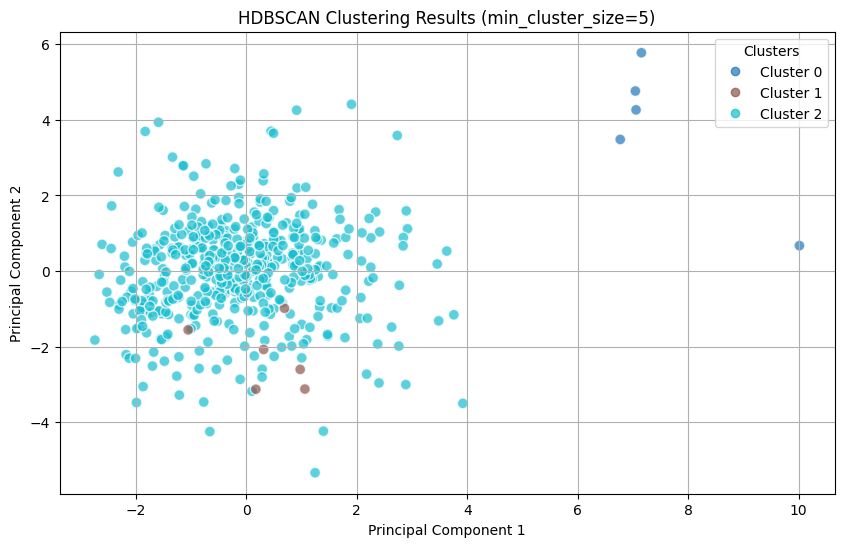

In [44]:
optimal_min_cluster_size = 5  # Adjust based on your analysis

# Perform HDBSCAN clustering with the optimal min_cluster_size
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=optimal_min_cluster_size,
    min_samples=1,
    metric='euclidean',
    cluster_selection_method='eom'
)
cluster_labels = clusterer.fit_predict(X_pca)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"Number of clusters found: {n_clusters}")

# Option A: 2D Visualization
plt.figure(figsize=(10, 6))

# Exclude noise points (optional)
mask = cluster_labels != -1
X_plot = X_pca[mask]
labels_plot = cluster_labels[mask]

scatter = plt.scatter(
    X_plot[:, 0], X_plot[:, 1],
    c=labels_plot,
    cmap='tab10',
    s=60,
    alpha=0.7,
    edgecolors='w'
)

# Add legend
handles, _ = scatter.legend_elements()
legend_labels = [f"Cluster {i}" for i in set(labels_plot)]
plt.legend(handles, legend_labels, title="Clusters", loc='best')

plt.title(f'HDBSCAN Clustering Results (min_cluster_size={optimal_min_cluster_size})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [46]:
from sklearn.metrics import silhouette_score

# Compute Silhouette Score (excluding noise points)
if len(set(cluster_labels)) > 1 and n_clusters > 1:
    score = silhouette_score(X_pca[cluster_labels != -1], cluster_labels[cluster_labels != -1])
    print(f"Silhouette Score (excluding noise): {score:.3f}")
else:
    print("Cannot compute Silhouette Score with less than 2 clusters.")


Silhouette Score (excluding noise): 0.440
